**The project accurcy is almost 41% only**
**trained on 10 epochs only**

# ***Import Libraries***

In [1]:
import os
import cv2
import json
import string
import numpy as np
import pickle as pkl
from random import shuffle
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow as imshow

import keras
import tensorflow as tf
from keras import Model
from keras.layers.merge import add
from keras.models import Sequential 
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils, data_utils
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.merge import Concatenate
from keras.layers import Dense, Conv2D, LSTM, Embedding ,Dropout, Activation, Input 

# **Creating Custom Tokenizer**
- **remove rare words**
- **replace rare word with "\<UNK>" token**

In [2]:
class Tokenizer():
  def __init__(self):
    self.VOCB_SIZE = 0
    
    self.deleted_words = list()
   
    self.word2int = dict()
    self.word2int['<UNK>'] = 0
    
    self.int2word = dict()
 
  def __len__(self):
    return self.VOCB_SIZE

  def fit_on_texts(self,all_text):
    words_to_delete = list()
    count_dictionary = dict()
    
    #count how many each word appears
    for line in all_text:
      for word in line:
        if word not in count_dictionary:
          count_dictionary[word] = 0  
        
        count_dictionary[word]+=1
    
    #prepare words to be deleted of it appears less than 2 times
    for key,value in count_dictionary.items():
      if value <2:
        words_to_delete.append(key)

    #delete rare words
    for word in words_to_delete:
      del count_dictionary[word]
    
    #create word to number dictionary
    i = 1
    for line in all_text:
      for word in line:
        if word in count_dictionary and word not in self.word2int:
          self.word2int[word] = i
          i+=1

    
    #create number to word dictionary
    self.int2word = {num:word for word,num in self.word2int.items()}

    self.VOCB_SIZE = len(list(self.word2int.items()))
    self.deleted_words = words_to_delete

  def texts_to_sequences(self,text):
    seq = list()
    for word in text:
      if word in self.deleted_words:
        seq.append(0)
      else:
        seq.append(self.word2int[word])
    
    return seq
  
  def sequences_to_text(self,sequence):
    txt = [self.int2word[num] for num in sequence]
    return txt




# **Loading Data**
- **Prepare Drive**
- **Load Actual Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/Weights

# delete the sameple folder data 
%rm -rf /content/sample_data

# copy resized images from drive
!cp "/content/drive/MyDrive/Colab Notebooks/Project 2/Original/Content Folder/MagicFile.F" "/content/"


Mounted at /content/drive


In [4]:
with open("/content/MagicFile.F", "rb") as f :
  train_list = pkl.load(f)
  val_list = pkl.load(f)
  all_text = pkl.load(f)
  tokenizer = pkl.load(f)
  VOCAB_SIZE = pkl.load(f)
  MAX_CAPTION_LENGHT = pkl.load(f)
  size_of_training_data = pkl.load(f)
  size_of_val_data = pkl.load(f)

  print("Number of unique words found %d" %VOCAB_SIZE)
  print("Size of longest caption line %d" %MAX_CAPTION_LENGHT)
  print("Number of training elements %d" %size_of_training_data)
  print("Number of validation elements %d" %size_of_val_data)

Number of unique words found 16759
Size of longest caption line 37
Number of training elements 118287
Number of validation elements 5000


#**Creating Sequances for LSTM**

In [5]:
def create_sequance(feature_map,caption_list):
  # X1 hold feature map , X2 hold input seq, Y hold output seq
  X1 , X2, Y = list(), list(), list()

  for caption in caption_list:
    seq = tokenizer.texts_to_sequences(caption)
    for i in range(1,len(seq)):
      in_seq ,out_seq = seq[:i], seq[i]
      in_seq = pad_sequences([in_seq], maxlen= MAX_CAPTION_LENGHT)[0]
      out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

      X1.append(feature_map)
      X2.append(in_seq)
      Y.append(out_seq)
    
  return X1, X2, Y

In [ ]:
# def create_sequance(feature_map,caption_list):
#   # X1 hold feature map , X2 hold input seq, Y hold output seq
#   X1 , X2, Y = list(), list(), list()

#   for caption in caption_list:
#     seq = tokenizer.texts_to_sequences(caption)
#     for i in range(1,len(seq)):
#       in_seq ,out_seq = seq[:i], seq[i]
#       in_seq = pad_sequences([in_seq], maxlen= MAX_CAPTION_LENGHT)[0]
#       out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

#       X1.append(feature_map)
#       X2.append(in_seq)
#       Y.append(out_seq)
  
#   return np.array(X1), np.array(X2), np.array(Y)


#**Data Generator**

In [8]:
def data_generator(input_list,batch_size):
  bc =0
  X1,X2,Y = list(),list(),list()
  while True:
    shuffle(input_list)
    for item in input_list:
      img = item[0]
      captions = item[1]
      
      x1,x2,y = create_sequance(img,captions)

      X1 += x1
      X2 += x2
      Y += y
      bc +=1
      
      if bc == batch_size:
        X1 = np.asarray(X1)
        X2 = np.asarray(X2)
        Y = np.asarray(Y)

        yield ([X1,X2], Y)
        bc = 0
        X1,X2,Y = list(),list(),list()


In [9]:
# class custom_generator(tf.keras.utils.Sequence):
#   def __init__(self,data_list,batch_size=16):
#     self.batch_size = batch_size
#     self.data_list = data_list
#     self.size_of_all = len(data_list)
#     self.on_epoch_end()
  
#   def __len__ (self):
#     return int(np.floor(self.size_of_all) / self.batch_size)
  
#   def on_epoch_end(self):
#     self.indexes = np.arange(len(self.data_list))
#     shuffle(self.data_list)

#   def __data_generation(self, list_of_ids):
#     F_MAP_LIST = np.empty((self.batch_size),1)
#     SEQ_LIST = np.empty((self.batch_size),1)
#     OUTPUT_LIST = np.empty((self.batch_size),1 )

#     for i, ID in enumerate(list_of_ids):
      
#       img = self.data_list[ID][0]
#       captions = self.data_list[ID][1]

#       x1,x2,y = create_sequance(img,captions)
      
#       F_MAP_LIST[i] = x1
#       SEQ_LIST[i] = x2
#       OUTPUT_LIST[i] = y
  
#     return [F_MAP_LIST,SEQ_LIST], OUTPUT_LIST


#   def __getitem__(self, index):
#     ids = self.indexes[index*self.batch_size : (index+1)*self.batch_size ]

#     X, Y = self.__data_generation(ids)

#     return X,Y



#**Design Model**

In [6]:
def create_lstm_model (lstm_size = 256):
  
  encoder_part = input1 = Input(shape=(2048,))
  encoder_part = Dropout(0.2)(encoder_part)
  encoder_part = Dense(lstm_size,activation='relu')(encoder_part)

  lstm_part = input2 = Input(shape=(MAX_CAPTION_LENGHT,))
  lstm_part = Embedding(VOCAB_SIZE, 256, mask_zero=True)(lstm_part)
  lstm_part = Dropout(0.2)(lstm_part)
  lstm_part = LSTM(lstm_size)(lstm_part)
  lstm_part = Dropout(0.2)(lstm_part)

  decoder_part = add([encoder_part, lstm_part])
  decoder_part = Dense(lstm_size,activation='relu')(decoder_part)
  decoder_part = output = Dense(VOCAB_SIZE,activation='softmax')(decoder_part)



  model = Model( inputs = [input1 , input2], outputs=output )

  model.compile(loss = 'categorical_crossentropy', optimizer='ADAM', metrics=['accuracy'])
  model.summary()  

  return model

#**Preparing and Compiling Model**

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 37, 256)      4290304     ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout_1 (Dropout)            (None, 37, 256)      0           ['embedding[0][0]']              
                                                                                              

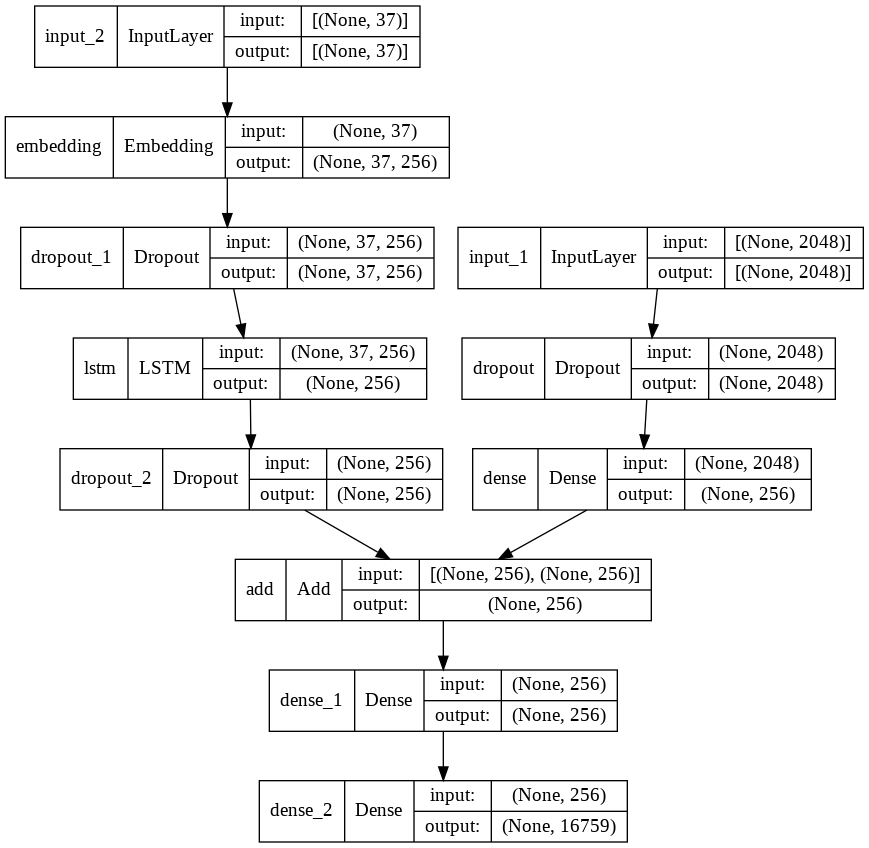

In [10]:
batch_size = 64
steps = size_of_training_data // batch_size
epochs = 10

train_generator = data_generator(train_list,batch_size)
val_generator = data_generator(val_list,100)



model = create_lstm_model()
plot_model(model,show_shapes=True)

In [11]:
!cp -r "/content/drive/MyDrive/Colab Notebooks/Project 2/Original/Weights/" "/content/"

In [14]:
model.load_weights("/content/Weights/model_auto11.h5")

#**Training Model**

In [ ]:
history_list = list()
for e in range(epochs):
  print("Epoch number : %d" %e)
  history = model.fit(train_generator,
                      epochs=1,
                      steps_per_epoch = steps,
                      verbose=1,
                      validation_data = val_generator,
                      validation_steps=50)
  
  history_list.append(history)
  model.save('/content/Weights/model_auto' + str(e+7) + '.h5')
  !cp -r "/content/Weights/" "/content/drive/MyDrive/Colab Notebooks/Project 2/Original/"

Epoch number : 0
1848/1848 [==============================] - 2231s 1s/step - loss: 2.7204 - accuracy: 0.4179 - val_loss: 2.9004 - val_accuracy: 0.4168


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch number : 1
1848/1848 [==============================] - 2222s 1s/step - loss: 2.6847 - accuracy: 0.4197 - val_loss: 2.9069 - val_accuracy: 0.4164
Epoch number : 2
 686/1848 [==========>...................] - ETA: 22:48 - loss: 2.6481 - accuracy: 0.4232

# Testing


In [15]:
#Download Testing Data
!wget http://images.cocodataset.org/zips/test2017.zip
!unzip /content/test2017.zip
!rm /content/test2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: test2017/000000251604.jpg  
 extracting: test2017/000000145034.jpg  
 extracting: test2017/000000234833.jpg  
 extracting: test2017/000000025927.jpg  
 extracting: test2017/000000393116.jpg  
 extracting: test2017/000000536478.jpg  
 extracting: test2017/000000365460.jpg  
 extracting: test2017/000000089887.jpg  
 extracting: test2017/000000274928.jpg  
 extracting: test2017/000000310028.jpg  
 extracting: test2017/000000229793.jpg  
 extracting: test2017/000000394339.jpg  
 extracting: test2017/000000564538.jpg  
 extracting: test2017/000000440585.jpg  
 extracting: test2017/000000541512.jpg  
 extracting: test2017/000000395525.jpg  
 extracting: test2017/000000235435.jpg  
 extracting: test2017/000000069964.jpg  
 extracting: test2017/000000131962.jpg  
 extracting: test2017/000000281392.jpg  
 extracting: test2017/000000534893.jpg  
 extracting: test2017/000000128676.jpg  
 extracting: test2017/000000187639.jpg  
 extra

In [16]:
origin_test_dir = '/content/test2017/'
img_list_dir =  os.listdir(origin_test_dir)

def resize_to_224(img_dir):
  img = cv2.imread(img_dir)
  img = cv2.resize(img,(224,224))
  cv2.imwrite(img_dir,img)

for path in os.listdir(origin_test_dir):
  resize_to_224(origin_test_dir+path)

In [17]:
EncoderNet = ResNet50(input_tensor=Input(shape=(224 , 224 , 3)),weights='imagenet',include_top=False,pooling='avg')
EncoderNet.trainable = False

def extract_feature_map(image_path):
  #assert size is (224,224) avoid any error
  img = load_img(image_path,target_size=(224,224))

  # add one dim at first (1,244,244,3) it will be used for batch size in future
  img = np.expand_dims(img, axis=0)
  img = EncoderNet.predict(img)
  img = np.reshape(img, img.shape[1])
  return img



94781440/94765736 [==============================] - 1s 0us/step


In [32]:
def seq_creator(caption):
  # X1 hold feature map , X2 hold input seq, Y hold output seq
  seq = tokenizer.texts_to_sequences(caption)
  i = len(seq)
  in_seq = seq[:i]
  in_seq = pad_sequences([in_seq], maxlen= MAX_CAPTION_LENGHT)[0]
    
  return np.asarray(in_seq)

In [41]:
def predict_img(img_id):
  end_word = " <end>"
  first_word = ["<start> "]
  img_path = origin_test_dir + img_id
  img = cv2.imread(img_path)
  imshow(img)
  caption = list()
  f_map = extract_feature_map(img_path)
  f_map = np.asarray(f_map)
  f_map = np.expand_dims(f_map,axis=0)
  input_word = first_word

  c = 0
  while c<37:
    c+=1
    seq = seq_creator(input_word)
    seq = np.expand_dims(seq,axis=0)
    
    predicted_word = np.argmax(model.predict([f_map,seq]))
    predicted_word = tokenizer.int2word[predicted_word]
    
    if predicted_word == end_word:
      break
    
    caption.append(predicted_word)
    input_word = caption


  print(caption)

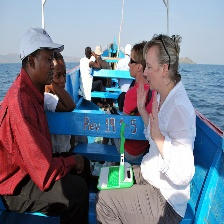

['man', 'sitting', 'at', 'table', 'with', 'laptop']


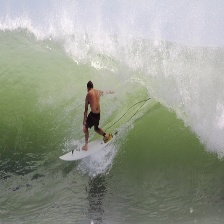

['man', 'on', 'surfboard', 'riding', 'wave']


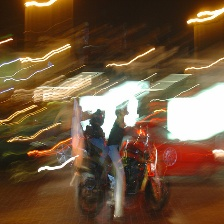

['man', 'riding', 'bike', 'down', 'street']


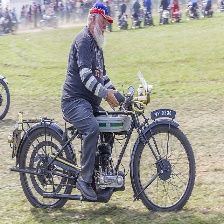

['man', 'on', 'dirt', 'bike', 'riding', 'on', 'the', 'road']


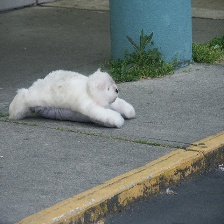

['white', 'polar', 'bear', 'laying', 'on', 'top', 'of', 'cement', 'block']


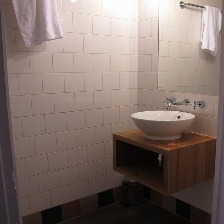

['bathroom', 'sink', 'and', 'toilet']


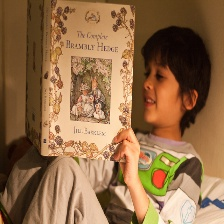

['woman', 'holding', 'baby', 'in', 'her', 'lap']


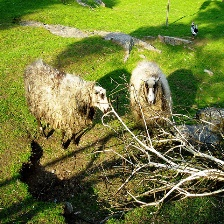

['two', 'sheep', 'are', 'standing', 'in', 'the', 'grass']


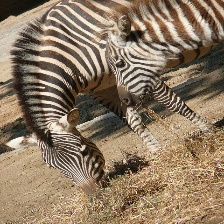

['two', 'zebras', 'are', 'standing', 'in', 'the', 'grass']


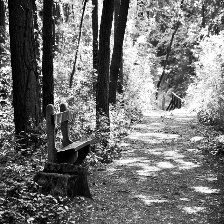

['man', 'sitting', 'on', 'bench', 'in', 'the', 'woods']


In [42]:
shuffle(img_list_dir)
for i, img_id in enumerate(img_list_dir):
  if i<10:
    predict_img(img_id)


  
